<a href="https://colab.research.google.com/github/mauricionoris/ae/blob/master/pratica/atv05_AG_Mutacao_Elitismo_Stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 5 — Mutação, Parâmetros, Elitismo e Critérios de Parada


## Objetivos
- Implementar um **Algoritmo Genético (AG)** modular que suporte diferentes **representações e operadores**.
- Explorar **mutação** (bit flip, gaussiana, swap), **crossover**, **elitismo** e **critérios de parada**.
- Gerar **visualizações** de *fitness* e **diversidade**.


In [1]:
import math, random, time
import numpy as np
import matplotlib.pyplot as plt

# Por segurança deste notebook: use apenas matplotlib (sem seaborn),
# um gráfico por figura, e sem setar cores explícitas (regras do ambiente).

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)
print("Versões: numpy", np.__version__)

Versões: numpy 2.0.2


## Funções de Fitness / Problemas
Três classes de problemas para exercitar as representações e operadores:
- **Binário (OneMax)**: maximizar o número de bits 1.
- **Real (Sphere / Rastrigin)**: minimizar funções contínuas (transformamos para maximização via negativo).
- **Permutação (TSP)**: minimizar o comprimento do percurso (novamente, maximizamos o negativo).

In [2]:
# --- Problema Binário: OneMax ---
def fitness_onemax(indiv):
    # indiv: vetor binário (0/1)
    return float(np.sum(indiv))  # já é maximização

# --- Problemas Reais: Sphere e Rastrigin (convertidos para maximização) ---
def f_sphere(x):
    return np.sum(np.array(x)**2)

def f_rastrigin(x):
    x = np.array(x)
    n = len(x)
    return 10*n + np.sum(x**2 - 10*np.cos(2*np.pi*x))

def fitness_sphere_max(x):
    # Maximiza o negativo da esfera (min sphere == max -sphere)
    return -float(f_sphere(x))

def fitness_rastrigin_max(x):
    return -float(f_rastrigin(x))

# --- Problema de Permutação: TSP (2D) ---
def tour_length(route, coords):
    # route: permutação de índices dos pontos
    total = 0.0
    for i in range(len(route)):
        a = coords[route[i]]
        b = coords[route[(i+1) % len(route)]]
        total += math.dist(a, b)
    return total

def fitness_tsp_max(route, coords):
    return -float(tour_length(route, coords))  # maximiza o negativo do comprimento

## Inicialização de População
Suportamos três representações: **binário**, **real** e **permutação**.

In [3]:
def init_population_binary(n_indiv=50, genome_length=64):
    return np.random.randint(0, 2, size=(n_indiv, genome_length), dtype=int)

def init_population_real(n_indiv=50, genome_length=10, bounds=(-5.12, 5.12)):
    low, high = bounds
    return np.random.uniform(low, high, size=(n_indiv, genome_length))

def init_population_perm(n_indiv=50, n_items=20):
    pop = []
    base = list(range(n_items))
    for _ in range(n_indiv):
        indiv = base[:]
        random.shuffle(indiv)
        pop.append(np.array(indiv, dtype=int))
    return np.array(pop, dtype=object)  # dtype=object para lidar bem com permutações

## Seleção
Usamos **Torneio** (tamanho `k`), que equilibra pressão seletiva e simplicidade.

In [4]:
def tournament_select(fitnesses, k=3):
    n = len(fitnesses)
    idxs = np.random.randint(0, n, size=k)
    best_i = idxs[np.argmax(fitnesses[idxs])]
    return best_i

## Crossover
- **Binário**: 1-ponto.
- **Real**: aritmético (convexo) por gene.
- **Permutação**: **OX** (*Order Crossover*).

In [5]:
def crossover_one_point(p1, p2):
    L = len(p1)
    if L < 2:
        return p1.copy(), p2.copy()
    cx = np.random.randint(1, L)  # ponto de corte em [1, L-1]
    c1 = np.concatenate([p1[:cx], p2[cx:]])
    c2 = np.concatenate([p2[:cx], p1[cx:]])
    return c1, c2

def crossover_arithmetic(p1, p2):
    # mistura convexa por gene com peso aleatório
    w = np.random.rand(*p1.shape)
    c1 = w*p1 + (1-w)*p2
    c2 = w*p2 + (1-w)*p1
    return c1, c2

def crossover_OX(p1, p2):
    # OX para permutações
    n = len(p1)
    a, b = sorted(np.random.choice(range(n), size=2, replace=False))
    c1 = [-1]*n
    c2 = [-1]*n
    # preserva fatias
    c1[a:b+1] = p1[a:b+1]
    c2[a:b+1] = p2[a:b+1]
    # completa na ordem de p2/p1
    def fill_child(c, parent_other, segment):
        n = len(parent_other)
        pos = (segment[1] + 1) % n
        for g in parent_other:
            if g not in c:
                c[pos] = g
                pos = (pos + 1) % n
        return c
    c1 = fill_child(c1, p2, (a, b))
    c2 = fill_child(c2, p1, (a, b))
    return np.array(c1, dtype=int), np.array(c2, dtype=int)

## Mutação
- **Bit Flip** para binário (prob. por gene `Pm`).
- **Gaussiana** para real (ruído `N(0, σ)` por gene, clip nos limites).
- **Swap** para permutação (troca duas posições com prob. `Pm`).

In [6]:
def mutate_bitflip(indiv, pm=0.01):
    mask = np.random.rand(len(indiv)) < pm
    if np.any(mask):
        indiv = indiv.copy()
        indiv[mask] = 1 - indiv[mask]
    return indiv

def mutate_gaussian(indiv, pm=0.1, sigma=0.1, bounds=(-5.12, 5.12)):
    # sigma pode ser float ou função sigma(gen, max_gens) -> float (tratado no loop do GA)
    mask = np.random.rand(len(indiv)) < pm
    if np.any(mask):
        indiv = indiv.copy()
        noise = np.random.normal(loc=0.0, scale=sigma, size=np.sum(mask))
        indiv[mask] = indiv[mask] + noise
        low, high = bounds
        indiv = np.clip(indiv, low, high)
    return indiv

def mutate_swap(indiv, pm=0.2, num_swaps=1):
    indiv = indiv.copy()
    if np.random.rand() < pm:
        n = len(indiv)
        for _ in range(num_swaps):
            i, j = np.random.choice(range(n), size=2, replace=False)
            indiv[i], indiv[j] = indiv[j], indiv[i]
    return indiv

## Métricas de Diversidade (simples)
- **Binário**: distância de Hamming média entre indivíduos (normalizada). [Detalhes](https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_de_Hamming)
- **Real**: desvio-padrão médio por gene.
- **Permutação**: fração média de posições diferentes entre pares (normalizada).

In [22]:
def hamming(x: str, y: str) -> int:
    assert len(x) == len(y), "Sequências devem ter o mesmo comprimento"
    return sum(a != b for a, b in zip(x, y))

def hamming_norm(x: str, y: str) -> float:
    d = hamming(x, y)
    return d / len(x)

# Exemplo:
print(hamming("101101", "100001"))      # 2
print(hamming_norm("101101", "100001")) # 0.333...

import numpy as np
x = np.array([1,0,1,1,0,1])
y = np.array([1,0,0,0,0,1])
d = np.sum(x != y)          # 2
d_norm = d / x.size         # 0.333...

print('numpy:',d,d_norm)

2
0.3333333333333333
numpy: 2 0.3333333333333333


In [7]:
def diversity_binary(pop):
    # média da distância de Hamming normalizada em pares amostrados
    n = len(pop)
    if n < 2: return 0.0
    idx = np.random.choice(n, size=min(n, 30), replace=False)  # amostra
    sub = pop[idx]
    L = sub.shape[1]
    dists = []
    for i in range(len(sub)):
        for j in range(i+1, len(sub)):
            d = np.sum(sub[i] != sub[j]) / L
            dists.append(d)
    return float(np.mean(dists)) if dists else 0.0

def diversity_real(pop):
    # desvio padrão médio por gene
    if len(pop) == 0: return 0.0
    std_per_gene = np.std(pop, axis=0)
    return float(np.mean(std_per_gene))

def diversity_perm(pop):
    # fração de posições diferentes (normalizada) em pares amostrados
    n = len(pop)
    if n < 2: return 0.0
    idx = np.random.choice(n, size=min(n, 30), replace=False)
    sub = pop[idx]
    L = len(sub[0])
    dists = []
    for i in range(len(sub)):
        for j in range(i+1, len(sub)):
            d = np.sum(sub[i] != sub[j]) / L
            dists.append(d)
    return float(np.mean(dists)) if dists else 0.0

## Motor do Algoritmo Genético
Parâmetros principais: `Pc`, `Pm`, `elitism_rate`, `max_gens`, `patience`, `target_fitness`.

Suporta `representation in {'binary','real','perm'}`.

In [8]:
def run_ga(
    representation="binary",
    fitness_fn=None,
    n_indiv=60,
    genome_length=64,
    bounds=(-5.12, 5.12),
    n_items_perm=20,
    pc=0.8,
    pm=0.01,
    elitism_rate=0.02,
    max_gens=200,
    patience=None,
    target_fitness=None,
    tournament_k=3,
    sigma=0.1,
    seed=None,
    tsp_coords=None
):
    if seed is not None:
        set_seed(seed)

    # Inicialização
    if representation == "binary":
        pop = init_population_binary(n_indiv, genome_length)
        crossover_fn = crossover_one_point
        mutate_fn = lambda ind, **kw: mutate_bitflip(ind, pm=pm)
        diversity_fn = diversity_binary
    elif representation == "real":
        pop = init_population_real(n_indiv, genome_length, bounds=bounds)
        crossover_fn = crossover_arithmetic
        # permite sigma ser número ou função (gen, max_gens)->sigma
        def _mut(ind, gen_idx=0, max_gens=max_gens):
            s = sigma(gen_idx, max_gens) if callable(sigma) else sigma
            return mutate_gaussian(ind, pm=pm, sigma=s, bounds=bounds)
        mutate_fn = _mut
        diversity_fn = diversity_real
    elif representation == "perm":
        n_items = n_items_perm
        pop = init_population_perm(n_indiv, n_items)
        crossover_fn = crossover_OX
        mutate_fn = lambda ind, **kw: mutate_swap(ind, pm=pm, num_swaps=1)
        diversity_fn = diversity_perm
    else:
        raise ValueError("representation inválida")

    # Avaliação inicial
    if representation == "perm":
        assert tsp_coords is not None, "Para permutação/TSP, forneça 'tsp_coords'."
        fits = np.array([fitness_fn(ind, tsp_coords) for ind in pop], dtype=float)
    else:
        fits = np.array([fitness_fn(ind) for ind in pop], dtype=float)

    elite_k = max(1, int(round(elitism_rate * n_indiv)))
    best_hist, mean_hist, div_hist = [], [], []
    best_so_far = -np.inf
    best_indiv = None
    no_improve = 0

    for gen in range(max_gens):
        # Estatísticas da geração
        best_idx = int(np.argmax(fits))
        best_fit = float(fits[best_idx])
        mean_fit = float(np.mean(fits))
        div_val = float(diversity_fn(pop))
        best_hist.append(best_fit)
        mean_hist.append(mean_fit)
        div_hist.append(div_val)

        if best_fit > best_so_far + 1e-12:
            best_so_far = best_fit
            best_indiv = pop[best_idx].copy()
            no_improve = 0
        else:
            no_improve += 1

        # Critérios de parada
        if target_fitness is not None and best_fit >= target_fitness:
            break
        if patience is not None and no_improve >= patience:
            break

        # Elitismo
        elite_idx = np.argsort(-fits)[:elite_k]
        elites = [pop[i].copy() for i in elite_idx]

        # Nova população via seleção + crossover + mutação
        new_pop = []
        while len(new_pop) < n_indiv - elite_k:
            p1 = pop[tournament_select(fits, k=tournament_k)]
            p2 = pop[tournament_select(fits, k=tournament_k)]
            if np.random.rand() < pc:
                c1, c2 = crossover_fn(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()

            if representation == "real":
                c1 = mutate_fn(c1, gen_idx=gen, max_gens=max_gens)
                c2 = mutate_fn(c2, gen_idx=gen, max_gens=max_gens)
            else:
                c1 = mutate_fn(c1)
                c2 = mutate_fn(c2)
            new_pop.append(c1)
            if len(new_pop) < n_indiv - elite_k:
                new_pop.append(c2)

        # Reavalia população
        if representation == "perm":
            new_pop = np.array(new_pop, dtype=object)
            new_fits = np.array([fitness_fn(ind, tsp_coords) for ind in new_pop], dtype=float)
        else:
            new_pop = np.array(new_pop)
            new_fits = np.array([fitness_fn(ind) for ind in new_pop], dtype=float)

        # Substitui, mantendo elites
        pop = np.concatenate([np.array(elites, dtype=object if representation=='perm' else pop.dtype), new_pop])
        if representation == "perm":
            fits = np.array([fitness_fn(ind, tsp_coords) for ind in pop], dtype=float)
        else:
            fits = np.array([fitness_fn(ind) for ind in pop], dtype=float)

    return {
        "best_hist": np.array(best_hist),
        "mean_hist": np.array(mean_hist),
        "div_hist": np.array(div_hist),
        "best_indiv": best_indiv,
        "best_fitness": float(best_so_far),
        "last_gen": len(best_hist)-1,
        "population": pop,
        "fitnesses": fits
    }

## Visualizações
Gráficos de **melhor** e **média do fitness** por geração, e **diversidade**.

In [9]:
def plot_history(history, title="Histórico do AG"):
    best = history["best_hist"]
    mean = history["mean_hist"]
    div = history["div_hist"]

    # Fitness
    plt.figure()
    plt.plot(best, label="Melhor")
    plt.plot(mean, label="Média")
    plt.title(title + " — Fitness")
    plt.xlabel("Geração")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

    # Diversidade
    plt.figure()
    plt.plot(div, label="Diversidade")
    plt.title(title + " — Diversidade")
    plt.xlabel("Geração")
    plt.ylabel("Diversidade (métrica simples)")
    plt.legend()
    plt.show()

def plot_tsp_route(route, coords, title="Rota TSP"):
    xs = [coords[i][0] for i in route] + [coords[route[0]][0]]
    ys = [coords[i][1] for i in route] + [coords[route[0]][1]]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    for idx, (x,y) in enumerate(coords):
        plt.text(x, y, str(idx))
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

## Demonstrações Rápidas
Execute as células abaixo para validar o motor em cada representação.

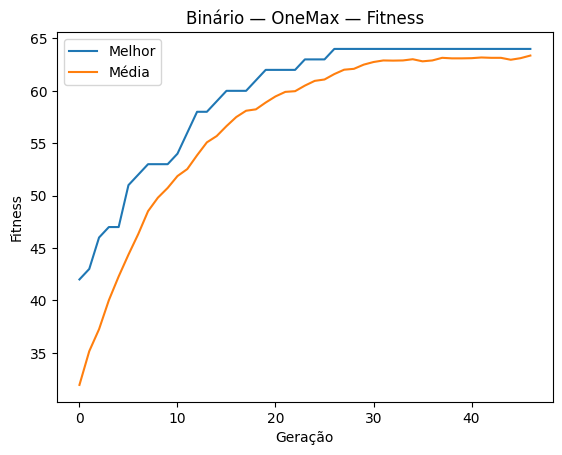

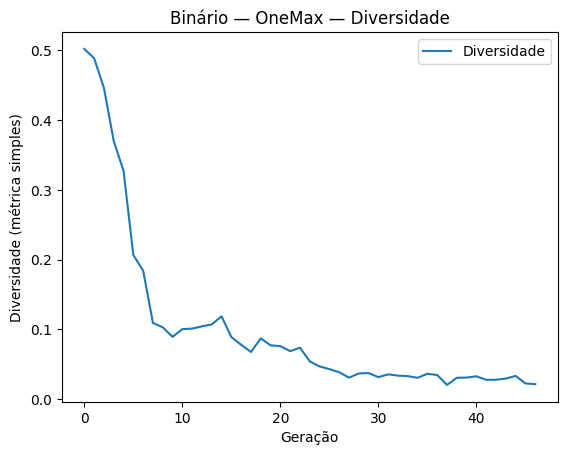

Best OneMax: 64.0


In [10]:
# Binário: OneMax (64 genes)
h_bin = run_ga(
    representation="binary",
    fitness_fn=fitness_onemax,
    n_indiv=60,
    genome_length=64,
    pc=0.9,
    pm=0.01,
    elitism_rate=0.02,
    max_gens=100,
    patience=20,
    seed=7
)
plot_history(h_bin, title="Binário — OneMax")
print("Best OneMax:", h_bin["best_fitness"])

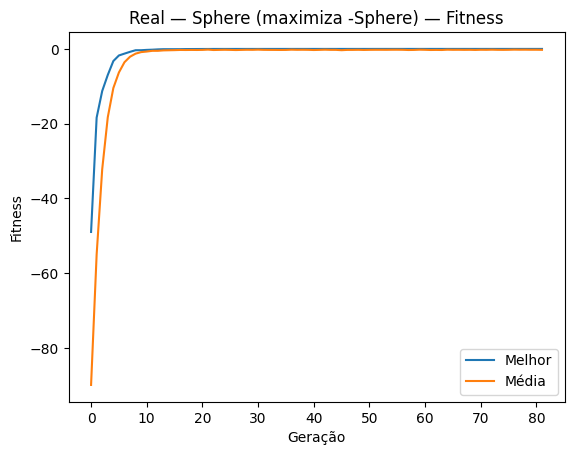

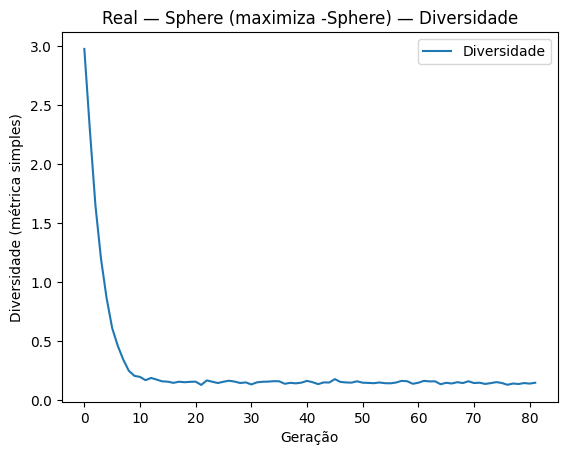

Best -Sphere: -0.003978542916677807


In [12]:
# Real: Sphere (10D)
h_real = run_ga(
    representation="real",
    fitness_fn=fitness_sphere_max,
    n_indiv=60,
    genome_length=10,
    bounds=(-5.12, 5.12),
    pc=0.8,
    pm=0.2,
    elitism_rate=0.02,
    sigma=0.3,
    max_gens=150,
    patience=30,
    seed=21
)
plot_history(h_real, title="Real — Sphere (maximiza -Sphere)")
print("Best -Sphere:", h_real["best_fitness"])

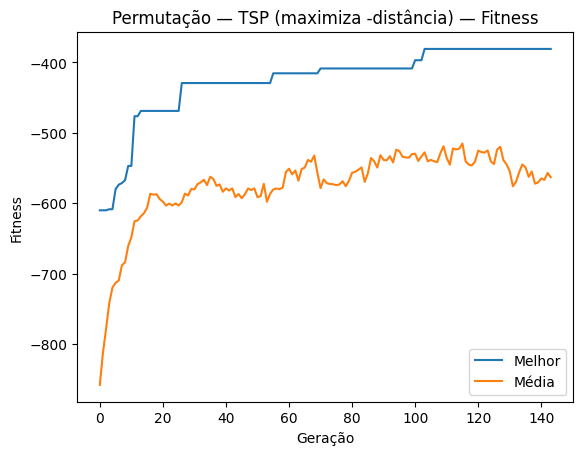

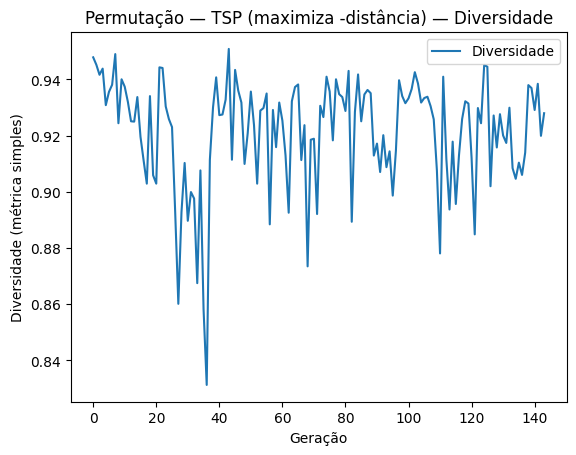

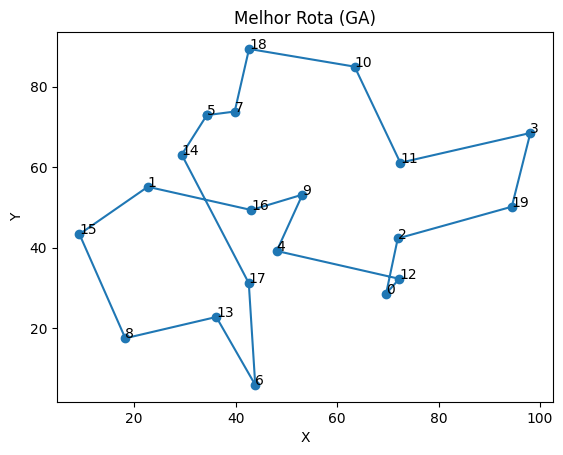

Melhor distância TSP: 380.8272771333807


In [13]:
# Permutação: TSP com 20 cidades aleatórias
np.random.seed(123)
coords = np.random.rand(20, 2) * 100.0  # 20 pontos em [0,100]^2

h_tsp = run_ga(
    representation="perm",
    fitness_fn=fitness_tsp_max,
    n_indiv=80,
    n_items_perm=20,
    pc=0.9,
    pm=0.3,
    elitism_rate=0.02,
    max_gens=150,
    patience=40,
    seed=42,
    tsp_coords=coords
)
plot_history(h_tsp, title="Permutação — TSP (maximiza -distância)")
best_route = h_tsp["best_indiv"]
plot_tsp_route(best_route, coords, title="Melhor Rota (GA)")
print("Melhor distância TSP:", -h_tsp["best_fitness"])

# Exercícios Práticos (Experimentos & Análise)

As tarefas a seguir priorizam **experimentos e análise**. A maior parte do código já está pronta; foque em **planejar comparações, executar cenários e interpretar os resultados**.

> **Dica geral**: Rode cada cenário **3–5 vezes** com *seeds* diferentes para reduzir viés de amostragem; reporte **médias e desvios** se possível.

## Exercício 1 — Efeito da Probabilidade de Mutação (Pm) no Binário (OneMax)
**Objetivo:** Medir como Pm afeta velocidade de convergência, fitness final e diversidade.

**Tarefa:**
1. Varie `pm` em `[0.001, 0.005, 0.01, 0.02, 0.05]` (mantenha `pc=0.9` e `elitism_rate=0.02`).
2. Para cada `pm`, rode **3 repetições** com *seeds* diferentes.
3. Plote o **fitness médio** por geração (agregando as repetições) e compare as curvas.
4. Analise o trade-off entre **exploração** (diversidade) e **estabilidade** (convergência).

**Perguntas de análise:**
- Qual `pm` entrega o melhor equilíbrio entre **tempo para convergir** e **fitness final**?
- Você observa **convergência prematura** para `pm` muito baixo?
- Para `pm` alto, há instabilidade que degrade o melhor fitness?

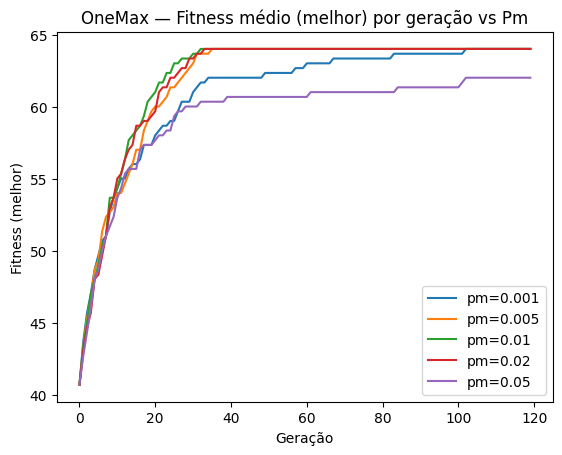

In [14]:
def experiment_onemax_vary_pm(pms=(0.001, 0.005, 0.01, 0.02, 0.05), reps=3, max_gens=120):
    curves = {}
    for pm in pms:
        runs = []
        for r in range(reps):
            h = run_ga(
                representation="binary",
                fitness_fn=fitness_onemax,
                n_indiv=60,
                genome_length=64,
                pc=0.9,
                pm=pm,
                elitism_rate=0.02,
                max_gens=max_gens,
                patience=None,
                seed=10+r
            )
            runs.append(h["best_hist"])
        # equaliza comprimentos (pode haver parada precoce)
        L = max(len(c) for c in runs)
        aligned = [np.pad(c, (0, L-l), constant_values=c[-1]) for c,l in zip(runs, map(len, runs))]
        curves[pm] = np.mean(np.vstack(aligned), axis=0)

    # Plot
    plt.figure()
    for pm, avg_curve in curves.items():
        plt.plot(avg_curve, label=f"pm={pm}")
    plt.title("OneMax — Fitness médio (melhor) por geração vs Pm")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (melhor)")
    plt.legend()
    plt.show()

experiment_onemax_vary_pm()
# TODO(análise): discuta os resultados obtidos e escolha um Pm recomendado para OneMax(64).

## Exercício 2 — Efeito do Elitismo em Problemas Reais (Rastrigin)
**Objetivo:** Avaliar impacto de diferentes taxas de elitismo na convergência e no risco de convergência prematura.

**Tarefa:**
1. Use **Rastrigin (10D)** com `pm=0.2`, `pc=0.8`, `sigma=0.3`, `max_gens=200`.
2. Compare `elitism_rate` em `[0.0, 0.02, 0.1]` (3 repetições cada).
3. Plote as curvas e **relate**: quando o elitismo ajuda e quando atrapalha?

**Perguntas de análise:**
- Elitismo alto acelera o ganho inicial, mas **reduz a diversidade**? Mostre no gráfico de diversidade.
- Há diferença significativa de **fitness final** entre os cenários?

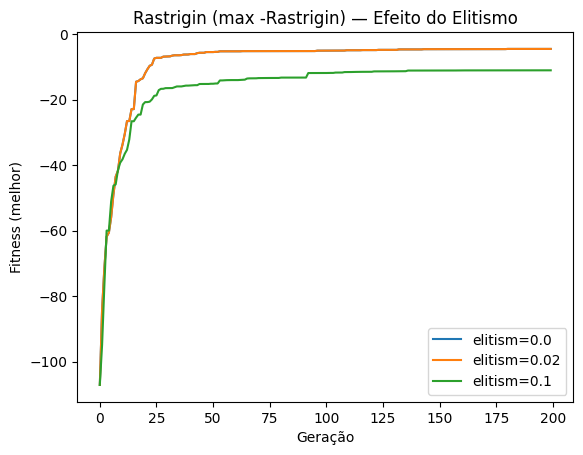

In [15]:
def experiment_rastrigin_elitism(elitism_rates=(0.0, 0.02, 0.1), reps=3, max_gens=200):
    curves = {}
    for er in elitism_rates:
        runs = []
        for r in range(reps):
            h = run_ga(
                representation="real",
                fitness_fn=fitness_rastrigin_max,
                n_indiv=60,
                genome_length=10,
                bounds=(-5.12, 5.12),
                pc=0.8,
                pm=0.2,
                elitism_rate=er,
                sigma=0.3,
                max_gens=max_gens,
                patience=None,
                seed=100+r
            )
            runs.append(h["best_hist"])
        L = max(len(c) for c in runs)
        aligned = [np.pad(c, (0, L-l), constant_values=c[-1]) for c,l in zip(runs, map(len, runs))]
        curves[er] = np.mean(np.vstack(aligned), axis=0)

    plt.figure()
    for er, avg in curves.items():
        plt.plot(avg, label=f"elitism={er}")
    plt.title("Rastrigin (max -Rastrigin) — Efeito do Elitismo")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (melhor)")
    plt.legend()
    plt.show()

experiment_rastrigin_elitism()
# TODO(análise): discuta as curvas de fitness e diversidade, apontando riscos de elitismo elevado.

## Exercício 3 — *Scheduling* de σ na Mutação Gaussiana
**Objetivo:** Comparar **σ fixo** vs **σ decaindo ao longo das gerações**.

**Tarefa:**
1. Use `Sphere (10D)` com `pc=0.8`, `pm=0.2`, `elitism_rate=0.02`.
2. Compare: (A) `sigma=0.5` (fixo) vs (B) `sigma(gen)=0.8 * (0.95**gen)` (decaimento exponencial).
3. Plote as curvas de fitness e discuta **exploração inicial** vs **refinamento final**.

**Perguntas de análise:**
- O agendamento de σ melhora tanto o **tempo para convergir** quanto o **fitness final**?
- Há diferença clara na **diversidade** ao longo das gerações?

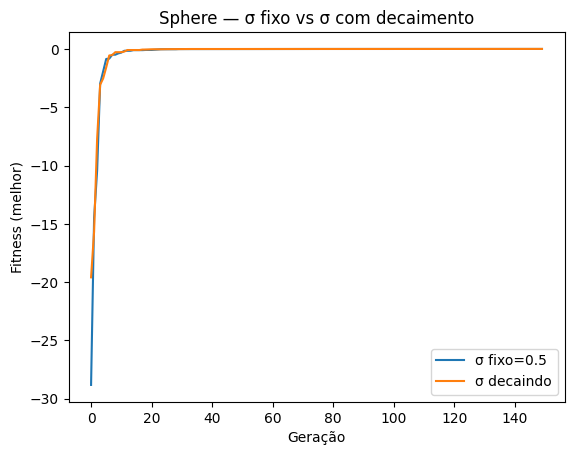

In [16]:
def sigma_decay(gen, max_gens):
    return 0.8 * (0.95 ** gen)

def experiment_sphere_sigma_schedule(max_gens=150):
    h_fixed = run_ga(
        representation="real",
        fitness_fn=fitness_sphere_max,
        n_indiv=60,
        genome_length=10,
        bounds=(-5.12, 5.12),
        pc=0.8,
        pm=0.2,
        elitism_rate=0.02,
        sigma=0.5,  # fixo
        max_gens=max_gens,
        patience=None,
        seed=2024
    )
    h_sched = run_ga(
        representation="real",
        fitness_fn=fitness_sphere_max,
        n_indiv=60,
        genome_length=10,
        bounds=(-5.12, 5.12),
        pc=0.8,
        pm=0.2,
        elitism_rate=0.02,
        sigma=sigma_decay,  # função
        max_gens=max_gens,
        patience=None,
        seed=2025
    )

    plt.figure()
    plt.plot(h_fixed["best_hist"], label="σ fixo=0.5")
    plt.plot(h_sched["best_hist"], label="σ decaindo")
    plt.title("Sphere — σ fixo vs σ com decaimento")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (melhor)")
    plt.legend()
    plt.show()

experiment_sphere_sigma_schedule()
# TODO(análise): escreva sua interpretação dos resultados vs exploração/refinamento.

## Exercício 4 — Mutação por *Swap* no TSP
**Objetivo:** Entender o papel da mutação **swap** (permuta duas posições) no TSP.

**Tarefa:**
1. Gere um conjunto de **30 cidades** (coords aleatórias).
2. Compare dois cenários: (A) `pm=0.0` (sem mutação) vs (B) `pm=0.3` (com swap).
3. Plote as curvas de fitness e visualize a **melhor rota** de cada cenário.
4. Discuta por que o TSP depende fortemente da **mutação** para escapar de ótimos locais.

**Perguntas de análise:**
- Sem mutação, o crossover sozinho consegue diversidade suficiente?
- O *swap* melhora a capacidade de **exploração** sem destruir a estrutura do tour?

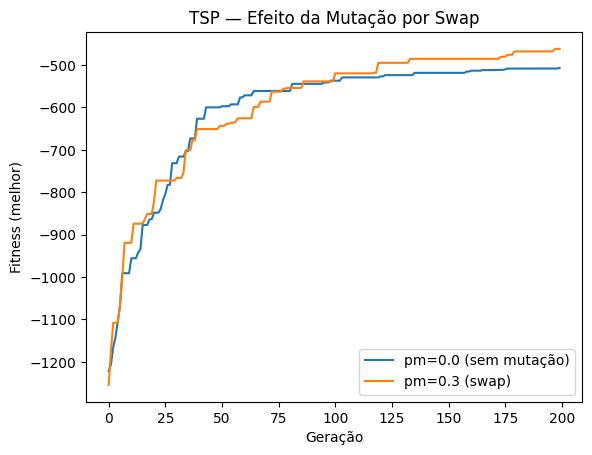

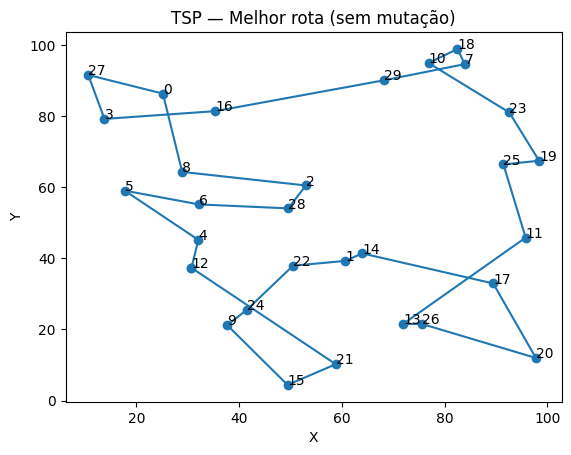

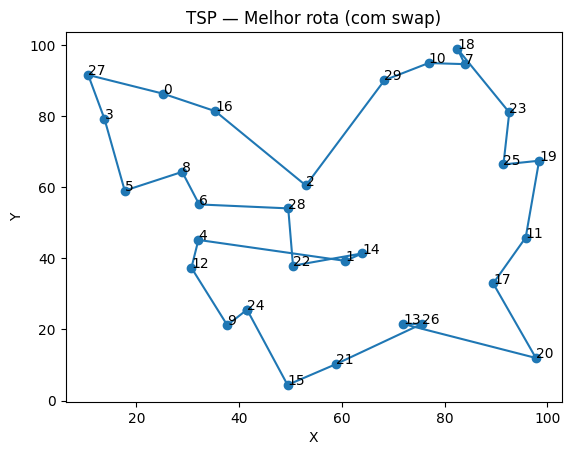

Distâncias: sem mutação = 506.71745411076085  | com swap = 462.0228749219507


In [17]:
def experiment_tsp_swap(n_cities=30, max_gens=200):
    coords = np.random.rand(n_cities, 2) * 100.0

    # Sem mutação
    h_no = run_ga(
        representation="perm",
        fitness_fn=fitness_tsp_max,
        n_indiv=80,
        n_items_perm=n_cities,
        pc=0.9,
        pm=0.0,
        elitism_rate=0.02,
        max_gens=max_gens,
        patience=60,
        seed=77,
        tsp_coords=coords
    )
    # Com swap
    h_yes = run_ga(
        representation="perm",
        fitness_fn=fitness_tsp_max,
        n_indiv=80,
        n_items_perm=n_cities,
        pc=0.9,
        pm=0.3,
        elitism_rate=0.02,
        max_gens=max_gens,
        patience=60,
        seed=78,
        tsp_coords=coords
    )

    plt.figure()
    plt.plot(h_no["best_hist"], label="pm=0.0 (sem mutação)")
    plt.plot(h_yes["best_hist"], label="pm=0.3 (swap)")
    plt.title("TSP — Efeito da Mutação por Swap")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (melhor)")
    plt.legend()
    plt.show()

    plot_tsp_route(h_no["best_indiv"], coords, title="TSP — Melhor rota (sem mutação)")
    plot_tsp_route(h_yes["best_indiv"], coords, title="TSP — Melhor rota (com swap)")
    print("Distâncias: sem mutação =", -h_no["best_fitness"], " | com swap =", -h_yes["best_fitness"])

experiment_tsp_swap()
# TODO(análise): discuta os impactos da mutação swap nos resultados (curvas e rotas).

## Exercício 5 — Critérios de Parada (máx. gerações vs estagnação vs alvo)
**Objetivo:** Comparar diferentes **critérios de parada** e seu impacto em **tempo de execução** e **qualidade**.

**Tarefa:**
1. Use `Rastrigin (10D)` com `pc=0.8`, `pm=0.2`, `elitism_rate=0.02`, `sigma=0.3`.
2. Cenários:
   - (A) `max_gens=200`, `patience=None`, `target=None`.
   - (B) `max_gens=1000`, `patience=40`.
   - (C) `max_gens=1000`, `target_fitness` definido (ex: atingir -5.0 no valor da função; lembre-se que estamos maximizando o negativo).
3. Compare *last_gen*, *best_fitness* e comente sobre **eficiência** vs **qualidade**.

**Perguntas de análise:**
- O critério de **estagnação** economiza tempo sem perda relevante de qualidade?
- Definir um **alvo** bem calibrado ajuda a encerrar cedo sem desperdiçar computação?

A) last_gen: 199 best: -4.528174718686543
B) last_gen: 104 best: -5.327444865481709
C) last_gen: 999 best: -6.032491244669117


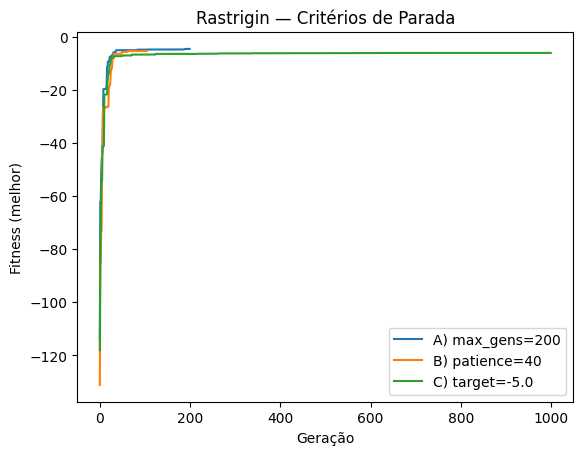

In [18]:
def experiment_stopping_rastrigin():
    # (A) máx. gerações fixo
    hA = run_ga(
        representation="real",
        fitness_fn=fitness_rastrigin_max,
        n_indiv=60, genome_length=10, bounds=(-5.12, 5.12),
        pc=0.8, pm=0.2, elitism_rate=0.02, sigma=0.3,
        max_gens=200, patience=None, target_fitness=None, seed=501
    )
    # (B) paciência
    hB = run_ga(
        representation="real",
        fitness_fn=fitness_rastrigin_max,
        n_indiv=60, genome_length=10, bounds=(-5.12, 5.12),
        pc=0.8, pm=0.2, elitism_rate=0.02, sigma=0.3,
        max_gens=1000, patience=40, target_fitness=None, seed=502
    )
    # (C) alvo de fitness (ex: -5.0 em -Rastrigin -> fitness >= -5.0)
    hC = run_ga(
        representation="real",
        fitness_fn=fitness_rastrigin_max,
        n_indiv=60, genome_length=10, bounds=(-5.12, 5.12),
        pc=0.8, pm=0.2, elitism_rate=0.02, sigma=0.3,
        max_gens=1000, patience=None, target_fitness=-5.0, seed=503
    )

    print("A) last_gen:", hA["last_gen"], "best:", hA["best_fitness"])
    print("B) last_gen:", hB["last_gen"], "best:", hB["best_fitness"])
    print("C) last_gen:", hC["last_gen"], "best:", hC["best_fitness"])

    plt.figure()
    plt.plot(hA["best_hist"], label="A) max_gens=200")
    plt.plot(hB["best_hist"], label="B) patience=40")
    plt.plot(hC["best_hist"], label="C) target=-5.0")
    plt.title("Rastrigin — Critérios de Parada")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (melhor)")
    plt.legend()
    plt.show()

experiment_stopping_rastrigin()
# TODO(análise): compare eficiência/qualidade entre critérios e justifique sua preferência.

## Conclusões (para você preencher)
- **Mutação** preserva diversidade e evita **convergência prematura**; calibrar `Pm` é crucial.
- **Elitismo** acelera, mas em excesso pode homogeneizar a população.
- **Critérios de parada** bem escolhidos economizam tempo mantendo a qualidade.

> **Tarefa final**: escreva um parágrafo resumindo seus achados nos 5 exercícios, incluindo **parâmetros recomendados** para cada cenário.